#Description:
    *Merging raw reads with PEAR
        

#Setting variables




In [1]:
seqDir = '/var/seq_data/RhizCG/150522_run1_rerun/raw/'

readFile1 = 'read1.fq.gz'
readFile2 = 'read2.fq.gz'

#Init

In [2]:
import os
import screed
import matplotlib.pyplot as plt
from mpltools import style
import numpy as np
from mpld3 import enable_notebook
import screed

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



##uncompressing 

In [5]:
!cd $seqDir; \
    pigz -k -d -p 24 read?.fq.gz

#Merging

In [6]:
!cd $seqDir; \
    pear -m 500 -j 24 \
    -f read1.fq \
    -r read2.fq \
    -o pear_merged-$(date +%F)

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.2 [March 26 2014]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: read1.fq
Reverse reads file.................: read2.fq
PHRED..............................: 33
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 500
Minimum assembly length............: 50
p-value............................: 0.010000
Quality score threshold (trimming).: 0
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 1.000000
Minimum overlap....................: 10
Scoring method.....................: Scaled score
Threads............................: 24

Allocating memory..................: 200,000,000 bytes
Computing empirical frequen

#Making a screed db of merged read

In [7]:
pear_merged_file = !echo "pear_merged-"$(date +%F)".assembled.fastq"
pear_merged_file = pear_merged_file[0]

os.chdir(seqDir)
screed.read_fastq_sequences(pear_merged_file)

pear_merged_file += '_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [8]:
pear_merged_file

'pear_merged-2015-06-03.assembled.fastq_screed'

In [13]:
lengths = []
for read in fqdb.itervalues():
    lengths.append((len(read["sequence"])))

In [15]:
style.use("ggplot")
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.hist(np.array(lengths), bins=50)
xl = ax.set_xlabel("Sequence Length, nt")
yl = ax.set_ylabel("Count")
fig.set_size_inches((10,6))

KeyError: 'ggplot2'

In [16]:
print 'Number of reads: {}'.format(len(lengths))

Number of reads: 8401290


#Quality stats on merged reads

In [18]:
def qualStats(sourceDir, fileName):
    outFile = fileName + '_qualStats'
    !cd $sourceDir; \
        fastx_quality_stats -i $fileName -o $outFile -Q 33
    return outFile
    
qualStatsRes = qualStats(seqDir, 'pear_merged-2015-06-03.assembled.fastq')

In [19]:
%%R -i seqDir -i qualStatsRes

setwd(seqDir)

# reading in qual-stats files    
tbl.r12 = read.delim(qualStatsRes, sep='\t')
rownames(tbl.r12) = 1:nrow(tbl.r12)

geom_smooth: method="auto" and size of largest group is <1000, so using loess. Use 'method = x' to change the smoothing method.


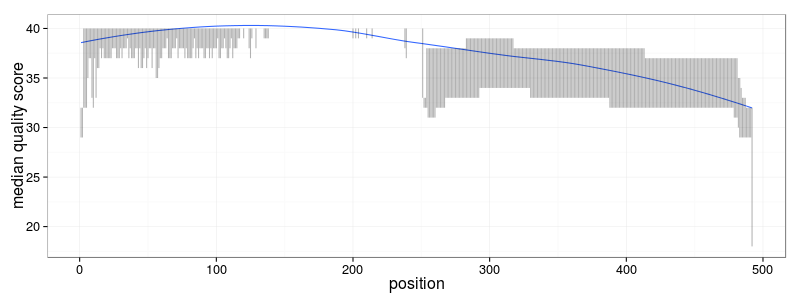

In [26]:
%%R -w 800 -h 300
# smooth curve on median qual values
ggplot(tbl.r12, aes(x=column, y=med, ymin=Q1, ymax=Q3)) +
    geom_smooth(se=FALSE) +
    geom_linerange(alpha=0.3) +
    labs(x='position', y='median quality score') +
    theme_bw() +
    theme( text = element_text(size=16) )